In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import pyflux as pf
from scipy.optimize import minimize
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas_datareader import DataReader
from datetime import datetime


In [59]:
NFLX = DataReader('NFLX',  'yahoo', datetime(2019,1,1), datetime(2019,12,31));
print(NFLX.head())

                  High         Low        Open       Close    Volume  \
Date                                                                   
2019-01-02  269.750000  256.579987  259.279999  267.660004  11679500   
2019-01-03  275.790009  264.429993  270.200012  271.200012  14969600   
2019-01-04  297.799988  278.540009  281.880005  297.570007  19330100   
2019-01-07  316.799988  301.649994  302.100006  315.339996  18620100   
2019-01-08  320.589996  308.010010  319.980011  320.269989  15359200   

             Adj Close  
Date                    
2019-01-02  267.660004  
2019-01-03  271.200012  
2019-01-04  297.570007  
2019-01-07  315.339996  
2019-01-08  320.269989  


In [80]:
faang = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
df = pd.DataFrame()
count = 0
for i in faang:
    stock = DataReader(i,'yahoo', datetime(2018,12,31), datetime(2019,12,31))['Close'].pct_change()
    if count < 1:
      
        date_range_df = pd.DataFrame({'Date': stock.keys().tolist()})
        df = pd.concat([df, date_range_df], axis=1)
        count = 1
    
    
    stock_df = pd.DataFrame({i: stock.values.tolist()})
    df = pd.concat([df, stock_df], axis=1)
    
""" Remove first row containing NaN """
df = df.set_index('Date')
FANG_Data = df.iloc[1:]
FANG_Data


,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2019-01-02,0.035014,0.024741,0.001141,0.000000,0.009888
2019-01-03,-0.029039,-0.025242,-0.099607,0.013226,-0.028484
2019-01-04,0.047138,0.050064,0.042689,0.097234,0.053786
2019-01-07,0.000725,0.034353,-0.002226,0.059717,-0.002167
2019-01-08,0.032452,0.016612,0.019063,0.015634,0.007385
...,...,...,...,...,...
2019-12-24,-0.005141,-0.002114,0.000951,0.000300,-0.003914
2019-12-26,0.013017,0.044467,0.019840,-0.001711,0.012534
2019-12-27,0.001492,0.000551,-0.000379,-0.010642,-0.006256


In [61]:
""" Calculate PCA components """

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(FANG_Data)
FANG_PCA = pca.transform(FANG_Data)
FANG_PCA_DF = pd.DataFrame(data=FANG_PCA, columns = ['principal component 1', 'principal component 2'])

FANG_PCA_DF


,principal component 1,principal component 2
0,0.026437,0.018406
1,-0.068998,-0.069686
2,0.131787,-0.025399
3,0.043566,-0.045169
4,0.037276,0.009545
...,...,...
247,-0.007376,-0.004404
248,0.031824,0.021897
249,-0.011147,0.006206
250,-0.028411,0.003584


In [81]:
NFLX.reset_index(drop=True, inplace=True)
FANG_PCA_DF.reset_index(drop=True, inplace=True)

df = pd.concat([NFLX, FANG_PCA_DF], axis=1) 

In [82]:
df

,High,Low,Open,Close,Volume,Adj Close,principal component 1,principal component 2
0,269.750000,256.579987,259.279999,267.660004,11679500,267.660004,0.026437,0.018406
1,275.790009,264.429993,270.200012,271.200012,14969600,271.200012,-0.068998,-0.069686
2,297.799988,278.540009,281.880005,297.570007,19330100,297.570007,0.131787,-0.025399
3,316.799988,301.649994,302.100006,315.339996,18620100,315.339996,0.043566,-0.045169
4,320.589996,308.010010,319.980011,320.269989,15359200,320.269989,0.037276,0.009545
...,...,...,...,...,...,...,...,...
247,335.700012,331.600006,334.010010,333.200012,2019300,333.200012,-0.007376,-0.004404
248,336.459991,332.010010,334.600006,332.630005,3589900,332.630005,0.031824,0.021897
249,333.820007,326.010010,332.959991,329.089996,5036100,329.089996,-0.011147,0.006206
250,329.190002,322.859985,329.079987,323.309998,4311500,323.309998,-0.028411,0.003584


#### Designing the OLS Model

In [83]:
def OLS(X, Y):
#     OLS estimator beta: N x 1
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ Y
    return beta_hat

In [84]:
def hypothesisValue(X, Y, Y_predict, coef):
# Choose Sample Size; Define X to be factors & columns
    T = len(X)  
    N = X.shape

# Residuals from OLS
    residual = Y - Y_predict
# variance of Y_predict or residuals
    sigma2 = residual.T @ residual / T
# standard deviation of Y_predict or residuals
    sigma = np.sqrt(sigma2)
    
# variance-covariance matrix of beta_hat
    varcov_beta_hat = sigma2 * np.linalg.inv(X.T @ X)
    std_beta_hat = np.sqrt(T * np.diag(varcov_beta_hat))
    
# Calculate R-square
    R_square = 1 - (sigma2*T) / (np.var(Y) * T)
    adj_R_square = 1 - (1-R_square) * (T-1) / (T-N[1])
    
# t-test & Significance level     
    t_stat = (coef.T)/std_beta_hat
    p_val_t = 1 - ss.norm.cdf(t_stat)
    
# Test of Joint Significance of Model
    F_stat = coef.T @ np.linalg.inv(varcov_beta_hat) @ coef * (T-N[1]) / (N[1] * residual.T @ residual)

    print('R-Square = ', R_square)
    print('\n')
    print('Adjusted R Square = ', adj_R_square)
    print('\n')
    print('T-test results = ', t_stat)
    print('\n')
    print('P-values =  ', p_val_t)
    print('\n')
    print('F_stat =', F_stat)
    print('\n')

    return t_stat, p_val_t, F_stat, R_square, adj_R_square

In [85]:
def getStats(X):
    Y = df[['Open']]
    X = np.array(X)
    Y = np.array(Y)
    X = X[:-1]
    Y = Y[1:]
    split = int(len(X)*0.1)
    X_train = X[:-split]
    X_test = X[-split:]
    Y_train = Y[:-split]
    Y_test = Y[-split:]
    coef = OLS(X_train,Y_train)
    two_coef = coef
    # print(coef)
    print('------------------------------------------')
    print('          Regression Statistics')
    print('------------------------------------------\n')
    print('Coefficients = ', coef)
    print('\n')

    y_predict = X_test @ coef
    t_stat1, p_val_t1, F_stat1, R_square1, Adj_R_square1 = hypothesisValue(X_test, Y_test, y_predict, coef)
    plt.figure(figsize=(20,10))
    plt.plot(range(len(Y_test)), Y_test)
    plt.plot(range(len(Y_test)), y_predict, marker='x')

    rms = sqrt(mean_squared_error(Y_test, y_predict))
    print('Root Mean Square Error = ',rms)
    plt.title('OLS Model')
    return t_stat1, p_val_t1, F_stat1, R_square1, Adj_R_square1

------------------------------------------
          Regression Statistics
------------------------------------------

Coefficients =  [[ -0.13637059]
 [  1.13624614]
 [-21.63619629]]


R-Square =  [[0.96244042]]


Adjusted R Square =  [[0.95902592]]


T-test results =  [[-0.16060811  1.33887614 -0.11588106]]


P-values =   [[0.56379897 0.0903055  0.5461266 ]]


F_stat = [[15873.87969284]]


Root Mean Square Error =  2.5992371572399295


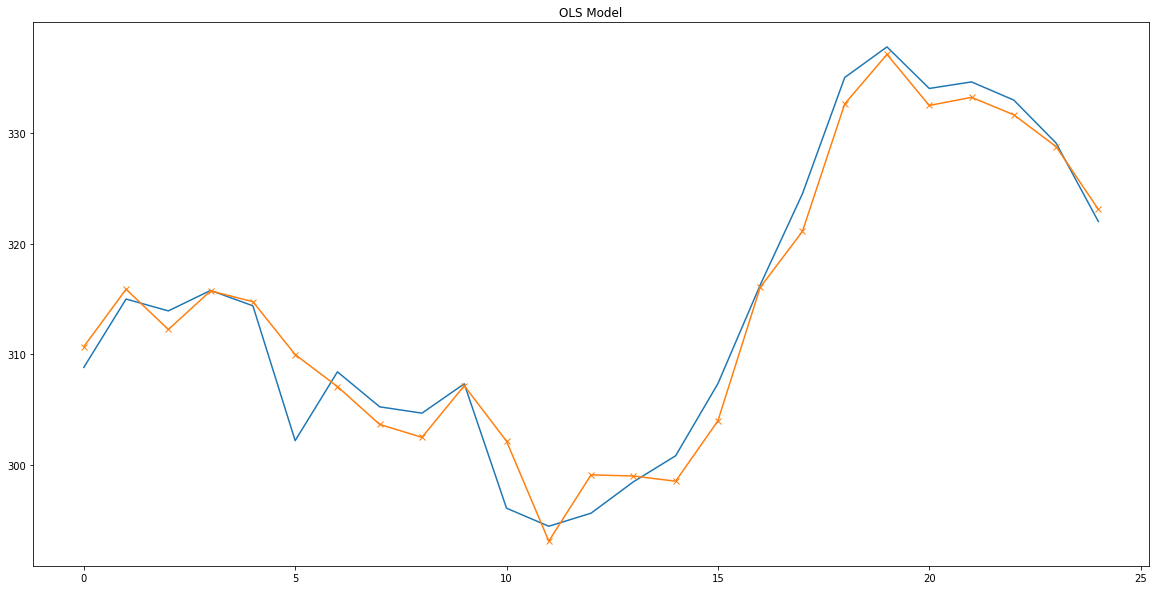

In [86]:
# Model 1 
# Features : 'Open','Close','principal component 1'

X = df[['Open','Close','principal component 1']]
t1, p1, f1, RSquare1, AdjRSquare1 = getStats(X)

------------------------------------------
          Regression Statistics
------------------------------------------

Coefficients =  [[   0.59875625]
 [   0.39931531]
 [-101.40543333]]


R-Square =  [[0.93511949]]


Adjusted R Square =  [[0.92922126]]


T-test results =  [[ 0.36961907  0.24132552 -0.33182865]]


P-values =   [[0.35583317 0.40465142 0.62999068]]


F_stat = [[5306.90587075]]


Root Mean Square Error =  3.4161953908936717


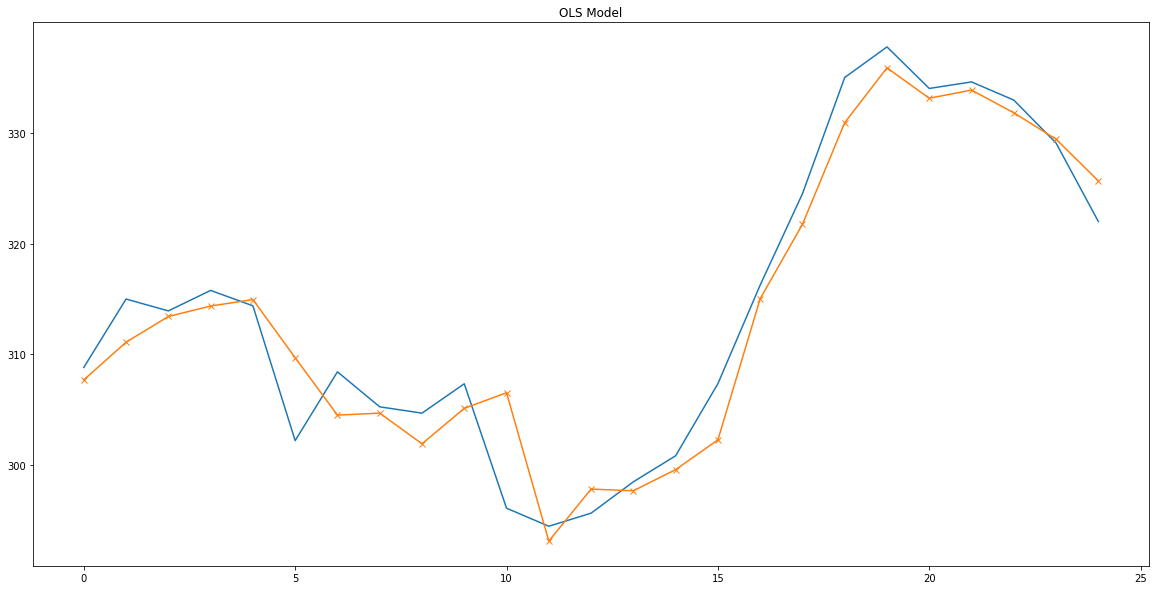

In [87]:
# Model 2
# Features : 'High', 'Low','principal component 2'

X = df[['High', 'Low','principal component 2']]
t2, p2, f2, RSquare2, AdjRSquare2 = getStats(X)

------------------------------------------
          Regression Statistics
------------------------------------------

Coefficients =  [[-1.64113381e-08]
 [ 1.00035050e+00]
 [-5.65699412e+00]
 [-3.38255892e+01]]


R-Square =  [[0.96084426]]


Adjusted R Square =  [[0.95525058]]


T-test results =  [[-1.45291606e-02  4.40417024e+01 -3.76282749e-02 -1.33233476e-01]]


P-values =   [[0.50579609 0.         0.51500797 0.55299563]]


F_stat = [[10457.98887148]]


Root Mean Square Error =  2.653892358400094


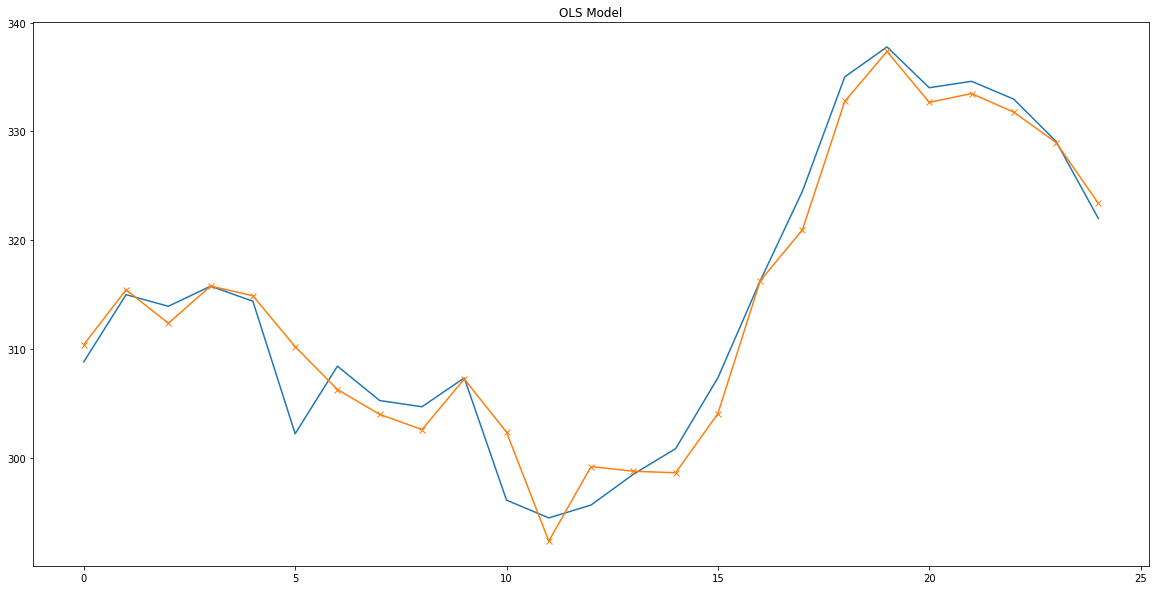

In [88]:
# Model 3
# Features : 'Volume', 'Close','principal component 1','principal component 2'

X = df[['Volume', 'Close','principal component 1','principal component 2']]
t3, p3, f3, RSquare3, AdjRSquare3 = getStats(X)

------------------------------------------
          Regression Statistics
------------------------------------------

Coefficients =  [[ 1.00058845e+00]
 [-5.13778428e-09]
 [ 1.11347933e+02]
 [-1.94655274e+02]]


R-Square =  [[0.92289544]]


Adjusted R Square =  [[0.9118805]]


T-test results =  [[ 3.15468525e+01 -3.25983960e-03  5.27491535e-01 -5.43473830e-01]]


P-values =   [[0.         0.50130049 0.29892615 0.7065982 ]]


F_stat = [[2695.55811974]]


Root Mean Square Error =  3.724136587107173


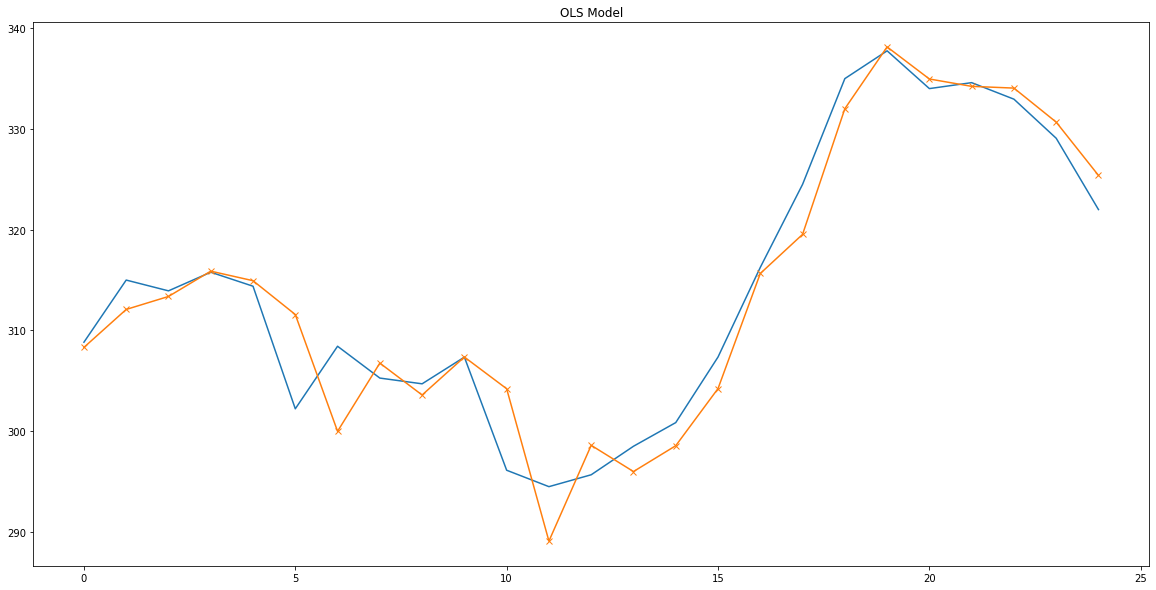

In [89]:
# Model 4
# Features : 'Open', 'Volume', 'principal component 1','principal component 2'

X = df[['Open', 'Volume', 'principal component 1','principal component 2']]
t4, p4, f4, RSquare4, AdjRSquare4 = getStats(X)

------------------------------------------
          Regression Statistics
------------------------------------------

Coefficients =  [[ 7.48603323e-01]
 [ 2.48941802e-01]
 [-1.49987666e-07]
 [ 5.23534711e+01]]


R-Square =  [[0.93509598]]


Adjusted R Square =  [[0.92582397]]


T-test results =  [[ 0.33581763  0.11058603 -0.07752268  0.27823001]]


P-values =   [[0.3685042  0.45597231 0.53089613 0.3904179 ]]


F_stat = [[3797.57376965]]


Root Mean Square Error =  3.416814290587365


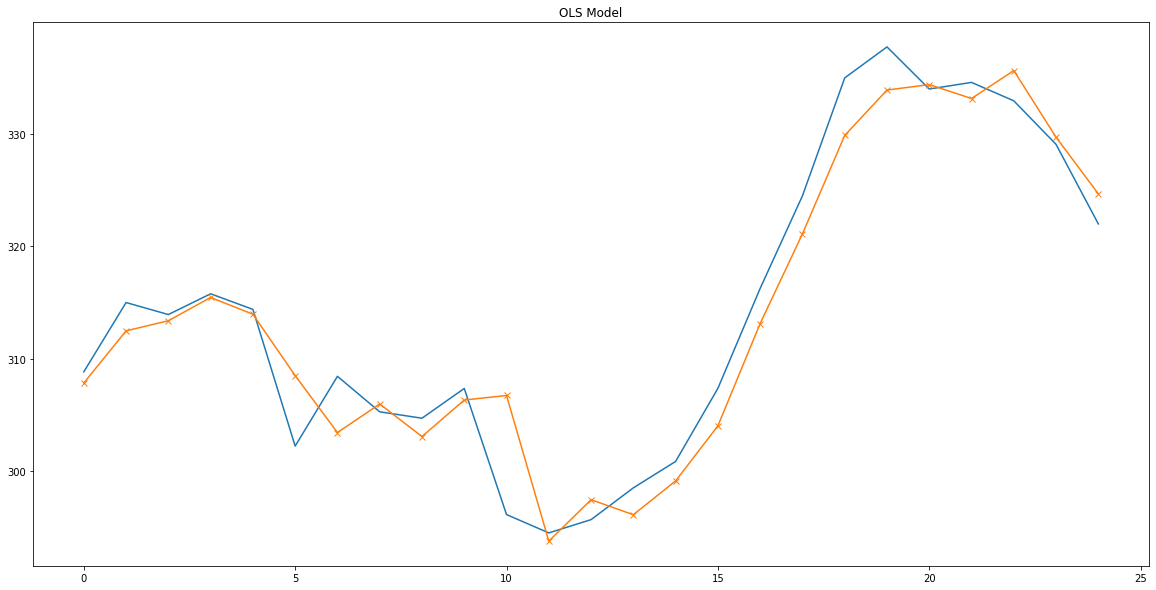

In [90]:
# Model 5
# Features : 'High', 'Low', 'Volume','principal component 1'

X = df[['High', 'Low', 'Volume','principal component 1']]
t5, p5, f5, RSquare5, AdjRSquare5 = getStats(X)

------------------------------------------
          Regression Statistics
------------------------------------------

Coefficients =  [[-1.09382106e-02]
 [ 1.01125918e+00]
 [-1.55546018e-08]
 [-3.22737513e+01]]


R-Square =  [[0.96226976]]


Adjusted R Square =  [[0.95687973]]


T-test results =  [[-0.01120959  1.03067573 -0.01342842 -0.09864744]]


P-values =   [[0.50447189 0.15134645 0.505357   0.5392909 ]]


F_stat = [[11263.80898709]]


Root Mean Square Error =  2.6051355995951586


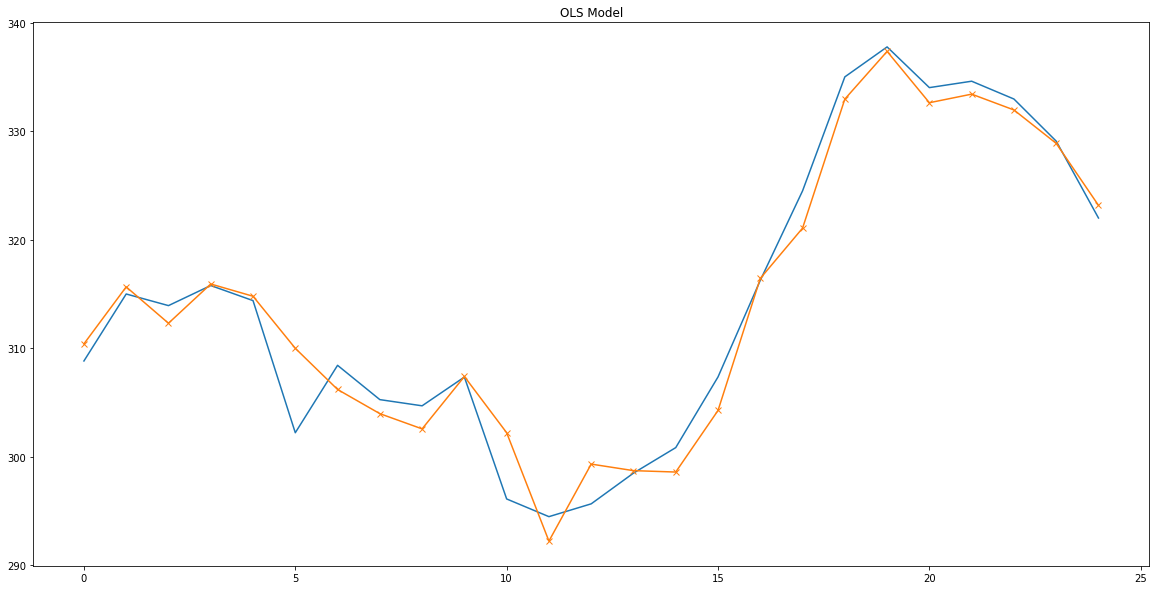

In [91]:
# Model 6
# Features : Open', 'Close', 'Volume','principal component 2'

X = df[['Open', 'Close', 'Volume','principal component 2']]
t6, p6, f6, RSquare6, AdjRSquare6 = getStats(X)

In [92]:
data = {'t_stat': [np.mean(t1), np.mean(t2), np.mean(t3), np.mean(t4), np.mean(t5), np.mean(t6)],
        'p_val': [np.mean(p1), np.mean(p2), np.mean(p3), np.mean(p4), np.mean(p5), np.mean(p6)],
        'F_stat': [f1, f2, f3, f4, f5, f6],
        'R_square': [RSquare1, RSquare2, RSquare3, RSquare4, RSquare5, RSquare6],
        'adj_R_square': [AdjRSquare1, AdjRSquare2, AdjRSquare3, AdjRSquare4, AdjRSquare5, AdjRSquare6]}
show = pd.DataFrame(data)
show['model'] = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6']
show.set_index('model')

,t_stat,p_val,F_stat,R_square,adj_R_square
model,,,,,
Model 1,0.354129,0.400077,[[15873.879692843277]],[[0.962440423055352]],[[0.959025916060384]]
Model 2,0.093039,0.463492,[[5306.905870751305]],[[0.9351194858081295]],[[0.9292212572452322]]
Model 3,10.964078,0.393450,[[10457.988871477974]],[[0.9608442554817335]],[[0.9552505776934097]]
Model 4,7.881903,0.376706,[[2695.5581197418014]],[[0.922895437013063]],[[0.9118804994435006]]
Model 5,0.161778,0.436448,[[3797.573769645902]],[[0.9350959753451202]],[[0.9258239718229946]]
Model 6,0.226848,0.425117,[[11263.80898709092]],[[0.9622697619270566]],[[0.9568797279166361]]


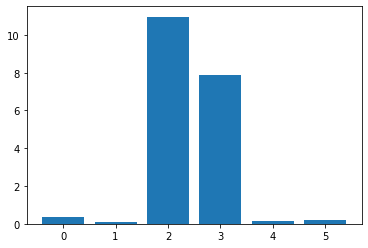

In [93]:
num_list = show['t_stat']  
plt.bar(range(len(num_list)), num_list)  
plt.show()  

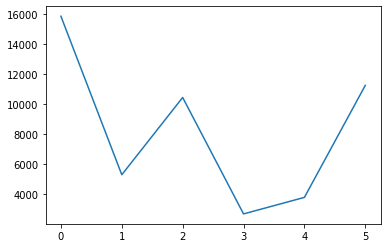

In [94]:
num_list = show['F_stat']  
plt.plot(range(len(num_list)), num_list)  
plt.show()  

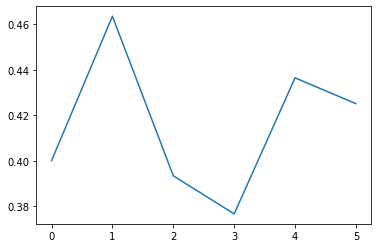

In [95]:
num_list = show['p_val']  
plt.plot(range(len(num_list)), num_list)  
plt.show()  

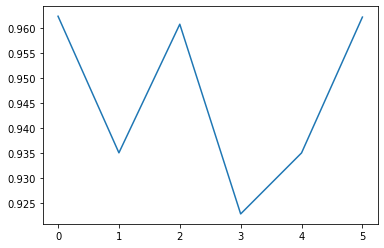

In [96]:
num_list = show[['R_square']]  
plt.plot(range(len(num_list)), num_list)  
plt.show()  

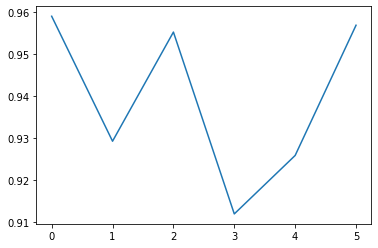

In [97]:
num_list = show[['adj_R_square']]  
plt.plot(range(len(num_list)), num_list)  
plt.show()  